In [146]:
import pandas as pd
import numpy as np
from jupyter_utils import jupyter_setup, load_tracker
import ipywidgets as widgets
jupyter_setup()
import plotly.graph_objects as go
import plotly.express as ex
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

C:\Michi\acoustic_covid_detection\python


In [147]:
tracker = load_tracker()
# tracker.summarize(detail="compact")

Loading Tracker from: C:/Michi/acoustic_covid_detection/python/run/tracker_saves/confidently_misclassified_samples/2023-07-19_resnet18_2023_06_25_logmel_combined_vowels_NEW_23msHop_96msFFT_fmax11000_224logmel_crossval_saveIDPerformance.pickle

Parameters used for finding the best performing epoch:
           metric_used:                   auc_roc
           smoothing:                     5
           ignore_first_n_epochs:         5


In [148]:
tracker.summarize(detail="compact")
# tracker.summarize(detail="detail")


Datasets used:
2023_06_25_logmel_combined_vowels_NEW_23msHop_96msFFT_fmax11000_224logmel
           dataset_class:                 <class 'datasets.ResnetLogmelDataset'>
           participants_file:             2023_06_25_logmel_combined_vowels_NEW_23msHop_96msFFT_fmax11000_224logmel.pickle
           augmented_files:               ['2023_06_25_logmel_combined_vowels_NEW_23msHop_96msFFT_fmax11000_224logmelaugmented.pickle']
           train_set_label_counts:        label '0': 851  -  label '1': 224
           types_of_recording:            combined_vowels

Audio Processing Parameters:
           type_of_features:              logmel
           n_time_steps:                  224
           n_features:                    224
           sample_rate:                   22050
           n_fft:                         8192
           window_length:                 2048
           hop_size:                      512
           fmin:                          0
           fmax:                 

In [149]:
pd.DataFrame(tracker.augmentations)

""


In [150]:
import pandas as pd
key = tracker.datasets.keys()
key=list(key)[0]
print(key)
print(tracker.model_and_training_parameters["compact"])
# pd.DataFrame(tracker.datasets[key], index = [0])
tracker.datasets[key]

2023_06_25_logmel_combined_vowels_NEW_23msHop_96msFFT_fmax11000_224logmel
{'model': 'ResNet', 'optimizer': 'Adam ', 'loss_function': 'sigmoid_focal_loss'}


{'dataset_class': datasets.ResnetLogmelDataset,
 'participants_file': '2023_06_25_logmel_combined_vowels_NEW_23msHop_96msFFT_fmax11000_224logmel.pickle',
 'augmented_files': ['2023_06_25_logmel_combined_vowels_NEW_23msHop_96msFFT_fmax11000_224logmelaugmented.pickle'],
 'train_set_label_counts': "label '0': 851  -  label '1': 224",
 'types_of_recording': 'combined_vowels'}

In [151]:
_ = widgets.interact(tracker.get_data_and_model_params, dataset_and_model=False, audio_processing=True, augmentations=False)

interactive(children=(Checkbox(value=False, description='dataset_and_model'), Checkbox(value=True, description…

# Compute Tracker Metrics:
when loading the tracker (load_tracker()), the recorded data will be loaded and preprocessed (cross validation mean/std and much more will be calculated). This is essential. Otherwise none of the following functionality works. You can call the preprocessing function manually (tracker.compute_overall_metrics()) to change the settings for processing. The available parameters are: <br>
- smooth_n_samples=10 <br>
This sets the number of samples over which a (weighted) moving average filter is applied before looking for a min/max of the curve or calculate the mean.
- ignore_first_n_epochs=5 <br>
Simply do not take the first n epochs into account when looking for a min/max
- metric_used_for_performance_analysis="auc_roc" <br>
The epoch on which the performance for all metrics will be evaluated for a specific run will be chosen by looking for the min/max in this metric. This means, that if the AUC ROC curve is chosen in the argument, it will look for the argmax of the AUC ROC curve and evaluate loss, accuracy, F1 etc in this exact epoch even when they have their extremum in another epoch  <br>

In [152]:
n_samples = 10
tracker.compute_overall_metrics(smooth_n_samples=n_samples, ignore_first_n_epochs=n_samples, metric_used_for_performance_analysis="auc_roc")


Parameters used for finding the best performing epoch:
           metric_used:                   auc_roc
           smoothing:                     10
           ignore_first_n_epochs:         10


# Evaluate the Cross Validation Results
For each run within a cross validation setting, the epoch of the min/max will be calculated and all metrics evaluated at this metric (after being smoothed as specified). The mean and std are calculated from the (in the default case) epoch where AUC ROC hits the global maximum. The resulting table can be adjusted with the jupyter widgets: <br>
- The styled table can be sorted by metric values (first drop down)  <br>
- by ticking "show_full_df" you can also display e.g. the standard deviation of each metric
- If you tick "highlight parameters" all hyperparameters, that changed thoughout the different runs, are highlighted by value. <br>
- The sliders below can be adjusted to filter out all runs with results worse than the slider setting  <br>
For more details (standard deviation e.g.), the cell below does exaclty the same but with 

In [153]:
def sortby(sort_descending_by_metric, highlight_hyperparameters, show_full_df, **kwargs):
    # thresholds = {"auc_roc": auc_threshold}
    if show_full_df:
        df = tracker.full_metric_performance_df
    else:
        df = tracker.compact_metric_performance_df
    style = tracker.style_metric_performance_df(df, sort_by=sort_descending_by_metric, highlight_hyperparameters=highlight_hyperparameters, filter_thresholds=kwargs)
    return style
_ = widgets.interact(sortby, sort_descending_by_metric=tracker.metrics_used, highlight_hyperparameters=True, show_full_df=False,
                auc_roc=widgets.FloatSlider(min=0.0, max=1.0, value=0.6, step=0.005),
                accuracy=widgets.FloatSlider(min=0.0, max=1.0, value=0.6, step=0.005),
                tpr=widgets.FloatSlider(min=0.0, max=1.0, value=0.4, step=0.005),
                tnr=widgets.FloatSlider(min=0.0, max=1.0, value=0.6, step=0.005)
                )

interactive(children=(Dropdown(description='sort_descending_by_metric', options=('auc_roc', 'loss', 'accuracy'…

# Box Plot the Hyperpaprameter Performances
Each metric is viewed separately. You can also choose to only look at the n_best performing hyperparameter runs. <br>
Depending on whether "sort_by_current_metric" is ticked this means something different. If it is not ticked, all runs will be sorted by the metric defined in the beginning (tracker.compute_overall_metrics()). Otherwise it will be sorted by the performance of the metric you have chosen to look at. This is very usefull  to get insight on which setting of a specific hyperparameter affects specific metrics. Some hyperparameter may for example improve the AUC ROC a bit but in the F1 or tnr metric they clearly hava a negative impact.

In [154]:
# hyperparameters = (list(tracker.crossval_runs[0].parameters.keys()))
options = tracker.get_only_varied_hyperparam_columns()
dropdown_colorby = widgets.Dropdown(options=[None, *options], value=options[0])

_ = widgets.interact(tracker.boxplot_run_statistics, metric=tracker.metrics_used,
                     show_n_best_runs=widgets.IntSlider(value=tracker.n_hyperparameter_runs, min=1, max=tracker.n_hyperparameter_runs),
                     color_by_hyperparameter=dropdown_colorby,
                     sort_by_current_metric=True)

interactive(children=(Dropdown(description='metric', options=('auc_roc', 'loss', 'accuracy', 'f1_score', 'auc_…

# Boxplots grouped by combinations excluding 1 hyperparameter
This way you can check the impact of 1 hyperparameter for each combination of other hyperparameters

In [155]:
options = tracker.get_only_varied_hyperparam_columns()
dropdown_groupby = widgets.Dropdown(options=options, value=options[0])

_ = widgets.interact(tracker.boxplot_groupedby_combination, metric=tracker.metrics_used,
                     show_n_best_runs=widgets.IntSlider(value=tracker.n_hyperparameter_runs, min=1, max=tracker.n_hyperparameter_runs),
                     # group_by_hyperparameter=["some", *tracker.get_only_varied_hyperparam_columns()],
                     separate_param=dropdown_groupby,
                     sort_by_current_metric=True,
                     boxgap=widgets.FloatSlider(value=0.1, min=0.0, max=1.0),
                     fontsize=widgets.IntSlider(value=12, min=6, max=20),
                    )

interactive(children=(Dropdown(description='metric', options=('auc_roc', 'loss', 'accuracy', 'f1_score', 'auc_…

Group hyperparameter combination by 1 parameter (opposite of before)

In [156]:
# options = tracker.get_only_varied_hyperparam_columns()
# dropdown_groupby = widgets.Dropdown(options=options, value=options[0])

# _ = widgets.interact(tracker.boxplot_run_statistics_grouped, metric=tracker.metrics_used,
#                      show_n_best_runs=widgets.IntSlider(value=tracker.n_hyperparameter_runs, min=1, max=tracker.n_hyperparameter_runs),
#                      # group_by_hyperparameter=["some", *tracker.get_only_varied_hyperparam_columns()],
#                      group_by_hyperparameter=dropdown_groupby,
                     
#                      sort_by_current_metric=True)

# Metric Performance over Epochs
Here we can analyze the cross validation mean of each hyperparameter run over the epochs. You can switch between train and eval mode and choose a specific metric to look at. The solid line is the mean over all folds within a crossval run. This is calculated epoch-wise, so at each epoch the smoothed metric performance of all folds is averaged. In the same way, the standard devaition is calculated and shown as area plot. <br>
You can choose to display the area plot (std) and also to view the fold within each crossval run + the epoch in which the in/max of the specified metric (in tracker.compute_overall_metrics()) was found. Additionally you can choose to view only the n best performing hyperparameter runs. The ranking is calculated by the metric set at the beginning (tracker.compute_overall_metrics()). <br>
You can change the number of samples to smooth the curves with. The default setting was also set in the compute_overall_metrics method. This is only for visualization and does not change the settings which are used to calculate the final crossval performance.<br>
Below is a similar method but it only shows 1 crossval run which can be switched with the dropdown menu.

In [157]:
# tracker.crossval_runs[0].runs[4].best_performances["eval"]
# tracker.crossval_runs[0].runs.pop(1)

In [158]:
options = tracker.get_only_varied_hyperparam_columns()
# if len(options) == 0:
#     options = [None]
dropdown_colorby = widgets.Dropdown(options=[None, *options], value=options[0])
_ = widgets.interact(tracker.show_all_runs, 
                     mode=["eval", "train", "test"], 
                     metric=tracker.metrics_used, 
                     n_samples_for_smoothing=widgets.IntSlider(value=tracker.performance_eval_params["smoothing"], min=1, max=15), 
                     show_separate_folds=True, 
                     show_std_area_plot=False,
                     show_n_best_runs=widgets.IntSlider(value=10, min=1, max=tracker.n_hyperparameter_runs),
                     color_by_hyperparameter=dropdown_colorby)

interactive(children=(Dropdown(description='mode', options=('eval', 'train', 'test'), value='eval'), Dropdown(…

In [159]:
def get_list_of_best_n_runs(sort_by_metric=True, metric="auc_roc"):
    # this way, the dropdown menu of run_id below is sorted by metric performance specified
    if sort_by_metric:
        hyperparameter_settings = [str(tracker.crossval_runs[idx].parameters) for idx in tracker.get_indices_of_best_n_runs(tracker.n_hyperparameter_runs, metric)]
    else:
        hyperparameter_settings = tracker.run_ids
    return hyperparameter_settings

In [160]:
_ = widgets.interact(tracker.show_single_run, 
                 run_id=get_list_of_best_n_runs(sort_by_metric=True, metric="auc_roc"),
                 # mode=["eval", "train"], 
                 metric=tracker.metrics_used, 
                 n_samples_for_smoothing=widgets.IntSlider(value=tracker.performance_eval_params["smoothing"], min=1, max=15), 
                 show_separate_folds=True, 
                 show_std_area_plot=True)

interactive(children=(Dropdown(description='run_id', options=("{'batch': '64', 'lr': '7e-05', 'wd': '0.0001', …

In [161]:

plt.plot(tracker.crossval_runs[0].runs[0].metrics["eval"]["auc_roc"])

NameError: name 'plt' is not defined

7e-05 True


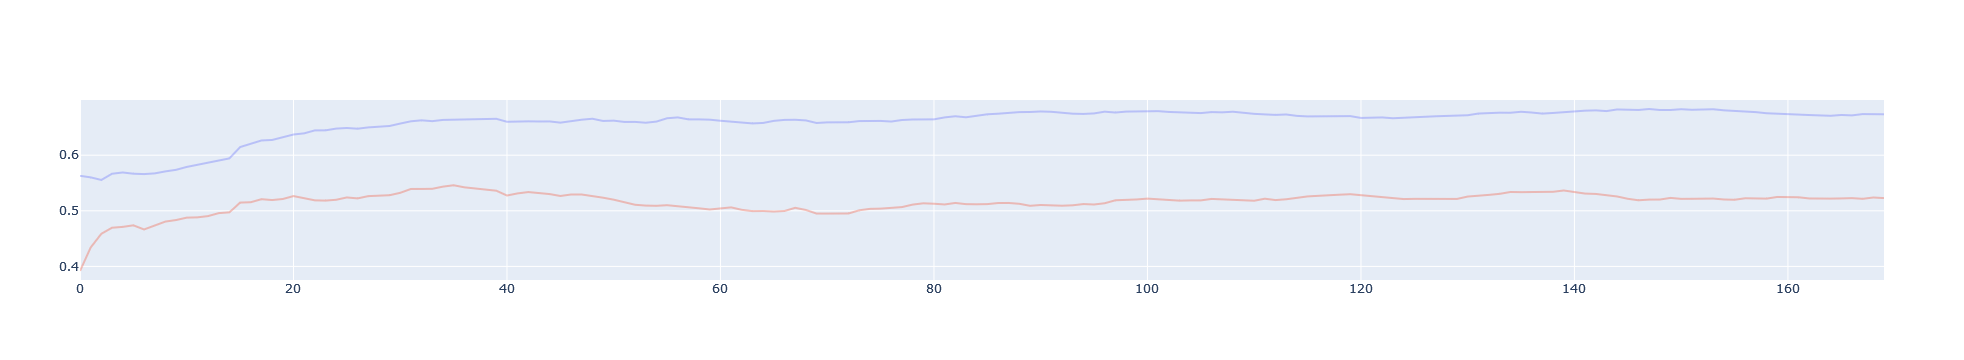

In [166]:
run_idx = 2
# metric = "auc_roc"
# metric = "accuracy"
# metric = "f1_score"
metric = "auc_prec_recall"
# metric = "tpr"
# metric = "tnr"
print(tracker.crossval_runs[run_idx].parameters["lr"], tracker.crossval_runs[run_idx].parameters["exclude_conf_miscl"])

n_samples_for_smoothing = 15
mode = "eval"
fig = go.Figure()
run = tracker.crossval_runs[run_idx].runs[0]
fold = run.get_metric(mode=mode, metric=metric, n_samples_for_smoothing=n_samples_for_smoothing)
fig.add_trace(go.Scatter(y=fold, opacity=0.35, showlegend=False, name="fold", legendgroup=name))

mode = "test"
fold = run.get_metric(mode=mode, metric=metric, n_samples_for_smoothing=n_samples_for_smoothing)
fig.add_trace(go.Scatter(y=fold, opacity=0.35, showlegend=False, name="fold", legendgroup=name))

# blue = eval data, red = test data

# Performance DatFrame for *test set*

In [19]:
def sortby(sort_descending_by_metric, highlight_hyperparameters, show_full_df, **kwargs):
    # thresholds = {"auc_roc": auc_threshold}
    if show_full_df:
        df =  tracker.get_metric_performance_df(include=("std", "params"), remove_columns=("fnr", "fpr"), set_name="test")
    else:
        df = tracker.get_metric_performance_df(include="params", remove_columns=("fnr", "fpr", "tpr_at_95"), set_name="test")

    style = tracker.style_metric_performance_df(df, sort_by=sort_descending_by_metric, highlight_hyperparameters=highlight_hyperparameters, filter_thresholds=kwargs)
    return style
_ = widgets.interact(sortby, sort_descending_by_metric=tracker.metrics_used, highlight_hyperparameters=True, show_full_df=False,
                auc_roc=widgets.FloatSlider(min=0.0, max=1.0, value=0.6, step=0.005),
                accuracy=widgets.FloatSlider(min=0.0, max=1.0, value=0.6, step=0.005),
                tpr=widgets.FloatSlider(min=0.0, max=1.0, value=0.4, step=0.005),
                tnr=widgets.FloatSlider(min=0.0, max=1.0, value=0.6, step=0.005)
                )

interactive(children=(Dropdown(description='sort_descending_by_metric', options=('auc_roc', 'loss', 'accuracy'…

In [125]:
pd.DataFrame(tracker.crossval_runs[2].best_performance_mean["test"], index=[0])


,auc_roc,loss,accuracy,f1_score,auc_prec_recall,precision,tpr_at_95,tpr,tnr,fpr,fnr
0,0.809296,0.416701,0.835376,0.405908,0.394078,0.32918,0.366173,0.548428,0.867931,0.132069,0.451572


In [35]:
def load_tracker(verbosity=None):
    root = tk.Tk()
    path = filedialog.askopenfilename(initialdir="run/tracker_saves", title="Select a File",
                                      filetypes=[("Pickled Tracker Files", "*.pickle*")])
    root.destroy()
    print(f"Loading Tracker from: {path}")
    with open(path, "rb") as f:
        tracker = pickle.load(f)

    tracker.compute_overall_metrics(smooth_n_samples=1, ignore_first_n_epochs=0,
                                    metric_used_for_performance_analysis="auc_roc")
    if verbosity is not None:
        tracker.summarize(verbosity)

    # print(f"\nTracker contains:\n>>  {tracker.n_hyperparameter_runs} <<  parameter runs\n"
    #       f">>  {tracker.k_folds_for_cross_validation} <<  folds per run\n"
    #       f">> {tracker.n_epochs} <<  epochs")
    return tracker


In [36]:
from tkinter import filedialog
import pickle

import tkinter as tk
tracker = load_tracker()

Loading Tracker from: C:/Michi/acoustic_covid_detection/python/run/tracker_saves/2023-07-11_Resnet18_MIL_2023_06_25_logmel_combined_speech_NEW_23msHop_46msFFT_fmax11000_224logmel_MIL_crossval.pickle

Parameters used for finding the best performing epoch:
           metric_used:                   auc_roc
           smoothing:                     1
           ignore_first_n_epochs:         0


In [ ]:
from torch import nn
from utils.utils import FocalLoss
import torch

In [ ]:
focal_loss = FocalLoss(gamma=0, pos_weight=1, reduction='mean',
                                      exclude_outliers=0)

In [ ]:
bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1]), reduction='mean')

In [ ]:
predictions = torch.tensor([0.0])
labels = torch.tensor([0.0])
predictions, labels.dtype

In [ ]:
focal_loss(predictions, labels)

In [ ]:
bce_loss(predictions, labels)

In [ ]:
dropout = nn.Dropout(p=0.0)


In [ ]:
dropout(torch.rand(10))